In [1]:
import os
import tools
import numpy as np
import pandas as pd
import scanpy as sc

sc.logging.print_header()

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.2 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1 pynndescent==0.5.2


In [2]:
os.chdir('/lustre/scratch117/cellgen/team297/kt16/COVID_imperial_renal')

In [3]:
# adata = sc.read_h5ad('h5ad/df.fil3_gex_kt.h5ad')
# adata

In [4]:
bdata = sc.read_h5ad('h5ad/df.fil3_gex_bcells_vdj.h5ad')
bdata

AnnData object with n_obs × n_vars = 75683 × 385
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartment

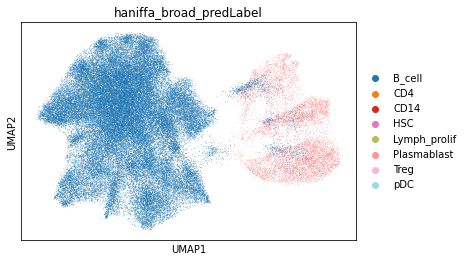

In [5]:
sc.pl.umap(bdata, color = ['haniffa_broad_predLabel'])

In [15]:
# subset to bcells and ASC separately
bcell = bdata[bdata.obs['celltype_B'] == 'B'].raw.to_adata()
ascs = bdata[bdata.obs['celltype_B'] == 'B_ASC'].raw.to_adata()

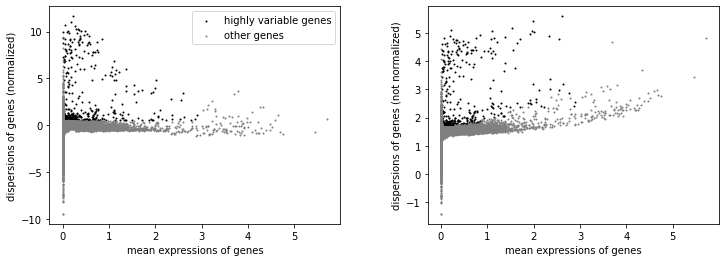

In [16]:
# find highly variable genes
sc.pp.highly_variable_genes(bcell, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(bcell)

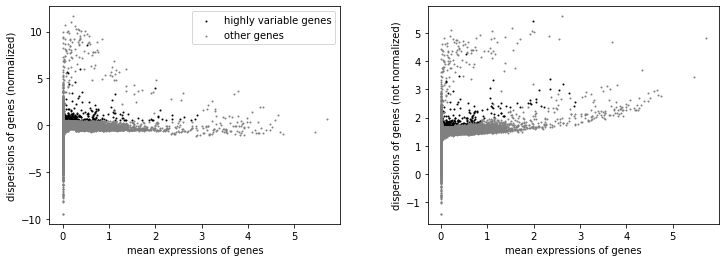

In [17]:
# remove vdj and light chain constant genes from highly variable genes, and also the viral reads
import re
for i in bcell.var.index:
    if re.search('^IG[HKL][VDJC]|VIRAL', i):
        bcell.var.at[i, 'highly_variable'] = False
sc.pl.highly_variable_genes(bcell)

In [18]:
# transfer to .raw slot
bcell.raw = bcell

In [19]:
# Filter the rna genes to only those marked as highly-variable
bcell = bcell[:, bcell.var.highly_variable].copy()
bcell

AnnData object with n_obs × n_vars = 66804 × 454
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartment

In [20]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
sc.pp.regress_out(bcell, ['nCount_RNA', 'pct_counts_mt'])
sc.pp.scale(bcell, max_value=10)

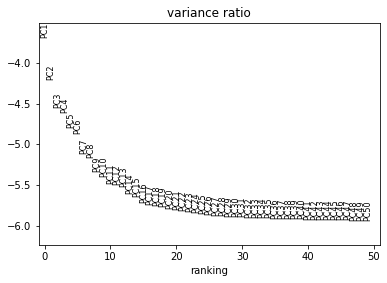

In [21]:
# Run PCA
sc.tl.pca(bcell, svd_solver='arpack')
sc.pl.pca_variance_ratio(bcell, log=True, n_pcs = 50)

In [22]:
# Correcting the PCs with harmonypy
sc.external.pp.harmony_integrate(bcell, 'sample_id', adjusted_basis = 'X_pca')
# Computing the neighborhood graph
sc.pp.neighbors(bcell, n_neighbors=10, n_pcs=30)
# Embedding the neighborhood graph
sc.tl.umap(bcell, min_dist = 0.3)

2021-12-13 11:07:13,113 - harmonypy - INFO - Iteration 1 of 10
2021-12-13 11:08:18,019 - harmonypy - INFO - Iteration 2 of 10
2021-12-13 11:09:21,108 - harmonypy - INFO - Converged after 2 iterations


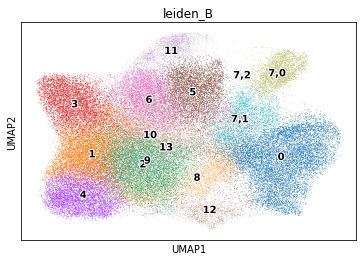

In [48]:
sc.tl.leiden(bcell, key_added = 'leiden_B')
sc.tl.leiden(bcell, key_added = 'leiden_B', restrict_to = ('leiden_B', ['7']), resolution = .3)
sc.pl.umap(bcell, color = 'leiden_B', legend_loc = 'on data', legend_fontoutline = 2)

In [45]:
def summarised_geneset_scores(self, genesets, groupby, figsize=(3, 4), cmap = 'viridis', col_cluster = True, row_cluster = True):
    import numpy as np
    import seaborn as sns
    # calculate average enrichment score
    list1 = list(set(self.obs[groupby]))
    subset = self.obs[[groupby] + [str(s) for s in genesets]]
    output = pd.DataFrame()
    for x in list1:
        subsetX = subset[subset[groupby] == x]
        outdict = {}
        for k in [str(s) for s in genesets]:
            out = {k:np.mean(subsetX[k])}
            outdict.update(out)
        output = output.append(outdict, ignore_index=True)
    output.index = list1
    output = output[[str(s) for s in genesets]]
    g = sns.clustermap(output.transpose(), standard_scale = 0, cmap=cmap, figsize=figsize, col_cluster = col_cluster, row_cluster = row_cluster)
    sc.pl.umap(self, color = [str(s) for s in genesets], size = 10, ncols = 2)
    print(g)

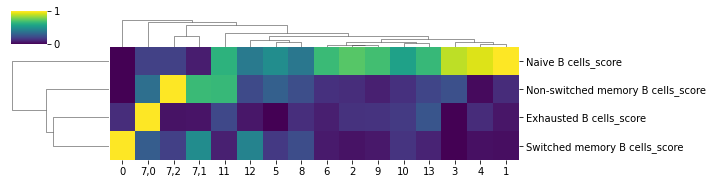

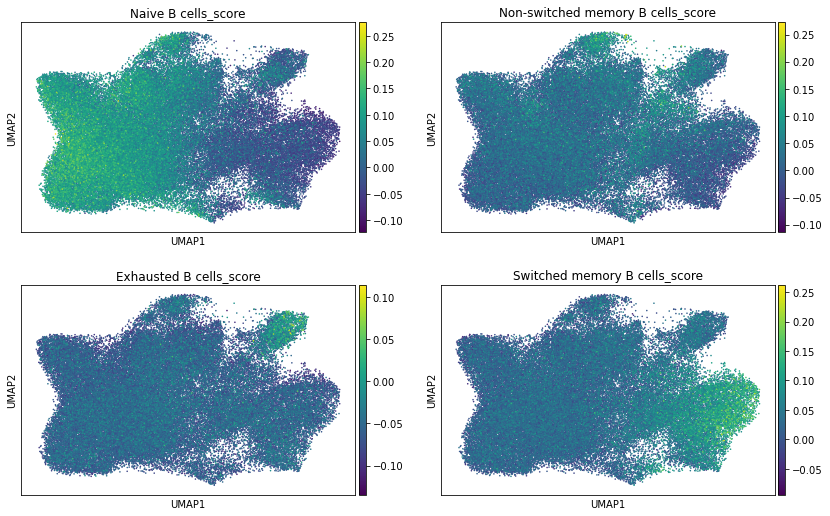

In [49]:
summarised_geneset_scores(bcell, ['Naive B cells_score', 
                                  'Non-switched memory B cells_score', 
                                  'Exhausted B cells_score', 
                                  'Switched memory B cells_score'], 
                          'leiden_B',
                          (10,2.5))

In [50]:
# read in the adt file
adt = sc.read_h5ad('h5ad/df.fil3_adt.h5ad')
badt = adt[adt.obs_names.isin(bcell.obs_names)].copy()
badt.obsm = bcell.obsm.copy()
badt.obs = bcell.obs.copy()
badt

AnnData object with n_obs × n_vars = 66804 × 137
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartment

In [51]:
sorted([l for l in badt.var_names])

['AB-ADGRG1',
 'AB-ANPEP',
 'AB-B3GAT1',
 'AB-BTLA',
 'AB-C5AR1',
 'AB-CCR4',
 'AB-CCR5',
 'AB-CCR6',
 'AB-CD101',
 'AB-CD14',
 'AB-CD163',
 'AB-CD19',
 'AB-CD1C',
 'AB-CD1D',
 'AB-CD2',
 'AB-CD22',
 'AB-CD226',
 'AB-CD24',
 'AB-CD244',
 'AB-CD27',
 'AB-CD274',
 'AB-CD28',
 'AB-CD33',
 'AB-CD36',
 'AB-CD38',
 'AB-CD3D',
 'AB-CD4',
 'AB-CD40',
 'AB-CD40LG',
 'AB-CD44',
 'AB-CD45',
 'AB-CD45RA',
 'AB-CD45RO',
 'AB-CD47',
 'AB-CD48',
 'AB-CD5',
 'AB-CD52',
 'AB-CD58',
 'AB-CD69',
 'AB-CD7',
 'AB-CD79B',
 'AB-CD81',
 'AB-CD82',
 'AB-CD83',
 'AB-CD86',
 'AB-CD8A',
 'AB-CD99',
 'AB-CLEC12A',
 'AB-CLEC4C',
 'AB-CR1',
 'AB-CR2',
 'AB-CTLA4',
 'AB-CX3CR1',
 'AB-CXCR3',
 'AB-CXCR5',
 'AB-DPP4',
 'AB-ENG',
 'AB-ENTPD1',
 'AB-FAS',
 'AB-FCER1A',
 'AB-FCER2',
 'AB-FCGR1A',
 'AB-FCGR2A',
 'AB-FCGR3A',
 'AB-GGT1',
 'AB-GP1BB',
 'AB-HLA-A',
 'AB-HLA-DRA',
 'AB-HLA-E',
 'AB-ICAM1',
 'AB-ICOS',
 'AB-IFNGR1',
 'AB-IGHD',
 'AB-IGHM',
 'AB-IGKC',
 'AB-IL2RA',
 'AB-IL2RB',
 'AB-IL3RA',
 'AB-IL4R',
 'AB-IL7R

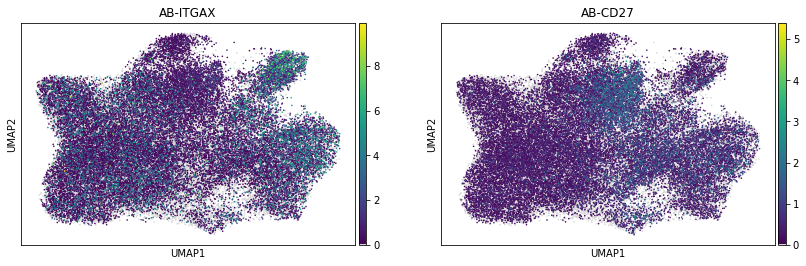

In [73]:
sc.pl.umap(badt, color = ['AB-ITGAX', 'AB-CD27'], color_map = tools.cmp(), size = 10)

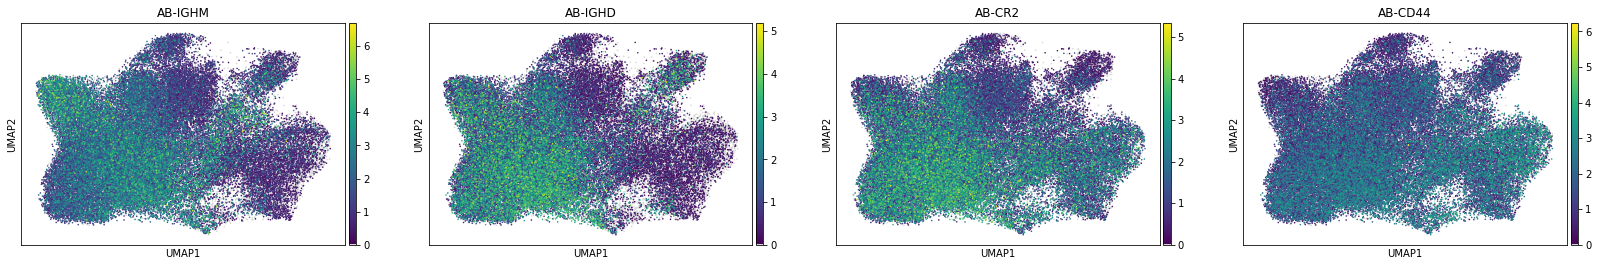

In [71]:
sc.pl.umap(badt, color = ['AB-IGHM', 'AB-IGHD', 'AB-CR2', 'AB-CD44'], color_map = tools.cmp(), size = 10)

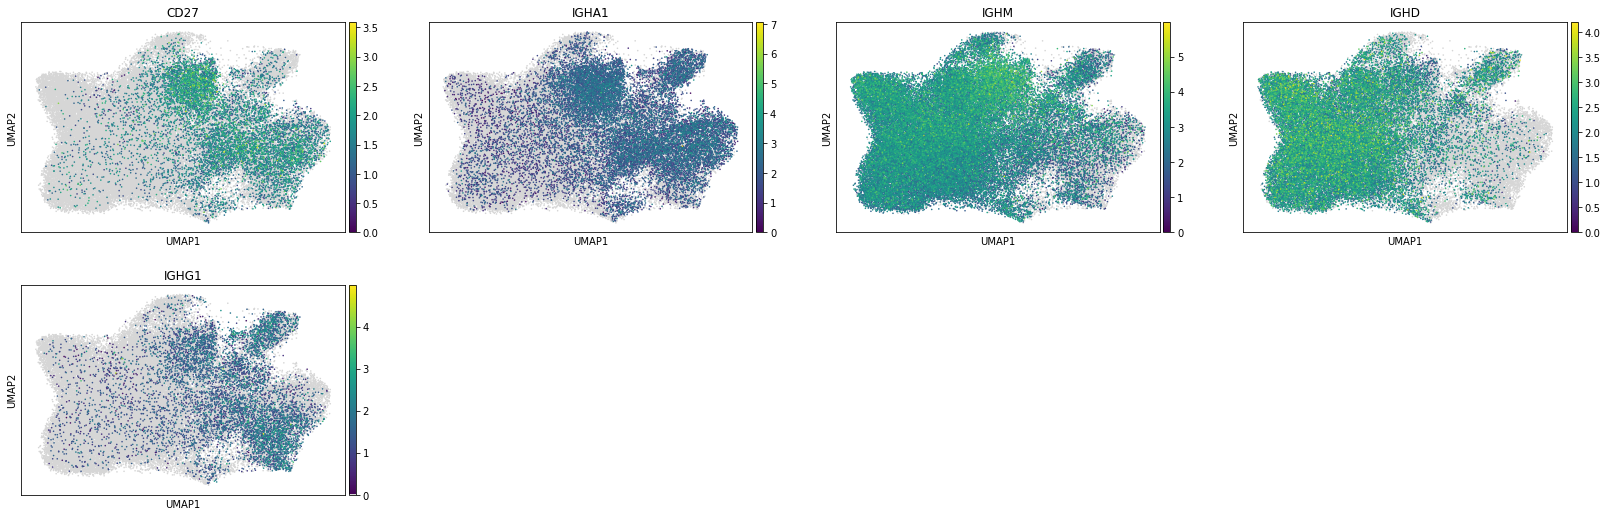

In [72]:
sc.pl.umap(bcell, color = ['CD27', 'IGHA1', 'IGHM','IGHD','IGHG1'], color_map = tools.cmp(), size = 10)

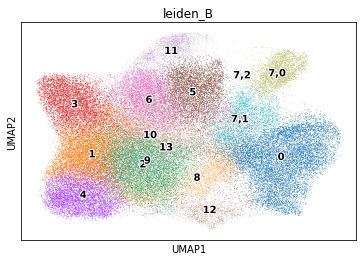

In [84]:
sc.pl.umap(bcell, color = 'leiden_B', legend_loc = 'on data', legend_fontoutline = 2)

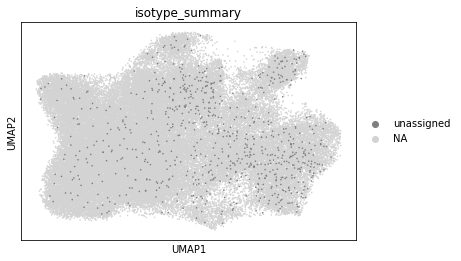

In [96]:
sc.pl.umap(bcell, color = 'isotype_summary', size = 10, groups = 'unassigned')

In [98]:
bcell.obs['has_contig'].value_counts()

True         59264
No_contig     7540
Name: has_contig, dtype: int64

In [99]:
ascs.obs['has_contig'].value_counts()

True         6721
No_contig    2158
Name: has_contig, dtype: int64

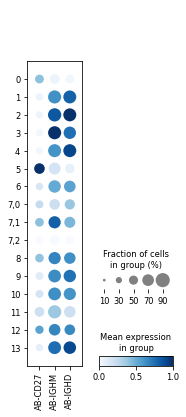

In [111]:
ax = sc.pl.dotplot(badt, ['AB-CD27', 'AB-IGHM','AB-IGHD'], groupby = 'leiden_B', color_map = 'Blues', standard_scale = 'var', return_fig = True)
ax.style(dot_edge_lw = 0, cmap = 'Blues')
ax.show()

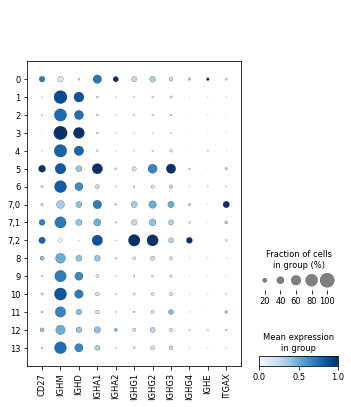

In [113]:
sc.pl.dotplot(bcell, ['CD27','IGHM','IGHD','IGHA1', 'IGHA2', 'IGHG1','IGHG2','IGHG3','IGHG4','IGHE','ITGAX'], groupby = 'leiden_B', color_map = 'Blues', standard_scale = 'var')

... storing 'celltype_B' as categorical


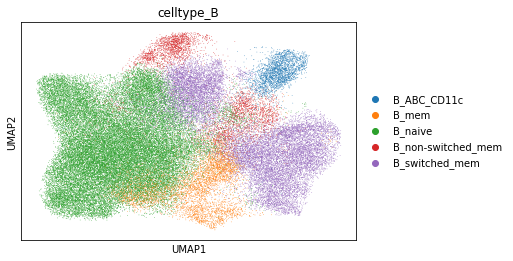

In [112]:
b_dict = {'0':'B_switched_mem',
'1':'B_naive',
'2':'B_naive',
'3':'B_naive',
'4':'B_naive',
'5':'B_switched_mem',
'6':'B_naive',
'7,0':'B_ABC_CD11c',
'7,1':'B_non-switched_mem',
'7,2':'B_switched_mem',
'8':'B_mem',
'9':'B_naive',
'10':'B_naive',
'11':'B_non-switched_mem',
'12':'B_mem',
'13':'B_naive',}
bcell.obs['celltype_B'] = [b_dict[x] for x in bcell.obs['leiden_B']]
sc.pl.umap(bcell, color = 'celltype_B')

In [131]:
bmem = bcell[bcell.obs['celltype_B'].isin(['B_mem', 'B_non-switched_mem', 'B_switched_mem'])].raw.to_adata()

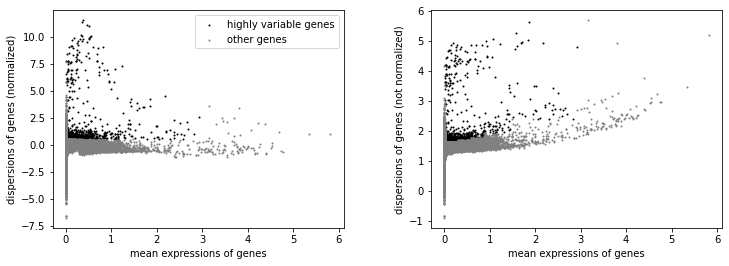

In [133]:
# find highly variable genes
sc.pp.highly_variable_genes(bmem, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(bmem)

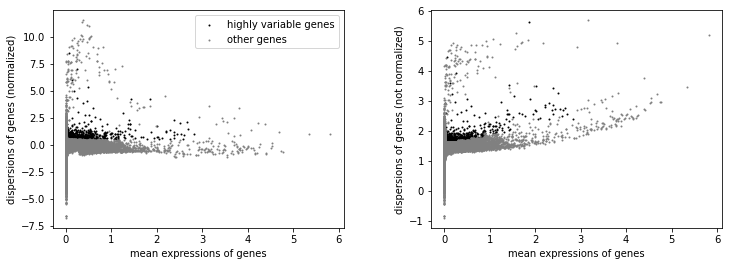

In [134]:
# remove vdj and light chain constant genes from highly variable genes, and also the viral reads
import re
for i in bmem.var.index:
    if re.search('^IG[HKL][VDJC]|VIRAL', i):
        bmem.var.at[i, 'highly_variable'] = False
sc.pl.highly_variable_genes(bmem)

In [135]:
# transfer to .raw slot
bmem.raw = bmem

In [136]:
# Filter the rna genes to only those marked as highly-variable
bmem = bmem[:, bmem.var.highly_variable].copy()
bmem

AnnData object with n_obs × n_vars = 25826 × 1075
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartmen

In [137]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
sc.pp.regress_out(bmem, ['nCount_RNA', 'pct_counts_mt'])
sc.pp.scale(bmem, max_value=10)

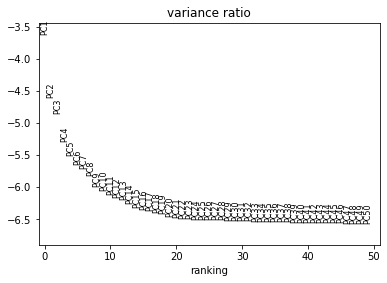

In [138]:
# Run PCA
sc.tl.pca(bmem, svd_solver='arpack')
sc.pl.pca_variance_ratio(bmem, log=True, n_pcs = 50)

In [139]:
# Correcting the PCs with harmonypy
sc.external.pp.harmony_integrate(bmem, 'sample_id', adjusted_basis = 'X_pca')
# Computing the neighborhood graph
sc.pp.neighbors(bmem, n_neighbors=10, n_pcs=30)
# Embedding the neighborhood graph
sc.tl.umap(bmem, min_dist = 0.3)

2021-12-13 12:03:27,273 - harmonypy - INFO - Iteration 1 of 10
2021-12-13 12:03:50,070 - harmonypy - INFO - Iteration 2 of 10
2021-12-13 12:04:11,536 - harmonypy - INFO - Converged after 2 iterations


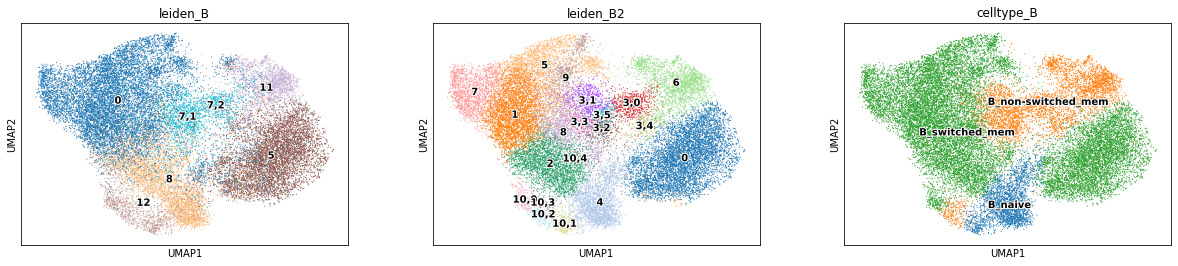

In [165]:
sc.tl.leiden(bmem, key_added = 'leiden_B2')
sc.tl.leiden(bmem, key_added = 'leiden_B2', restrict_to = ('leiden_B2', ['3']), resolution = .5)
sc.tl.leiden(bmem, key_added = 'leiden_B2', restrict_to = ('leiden_B2', ['10']), resolution = .5)
sc.pl.umap(bmem, color = ['leiden_B','leiden_B2', 'celltype_B'], legend_loc = 'on data', legend_fontoutline = 2)

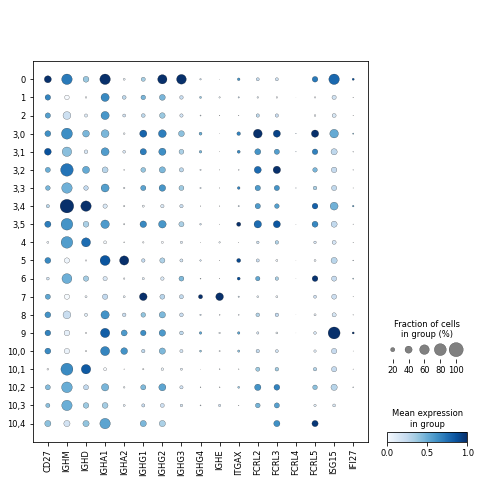

In [166]:
sc.pl.dotplot(bmem, ['CD27','IGHM','IGHD','IGHA1', 'IGHA2', 'IGHG1','IGHG2','IGHG3','IGHG4','IGHE','ITGAX', 'FCRL2','FCRL3','FCRL4','FCRL5', 'ISG15', 'IFI27'], groupby = 'leiden_B2', color_map = 'Blues', standard_scale = 'var')

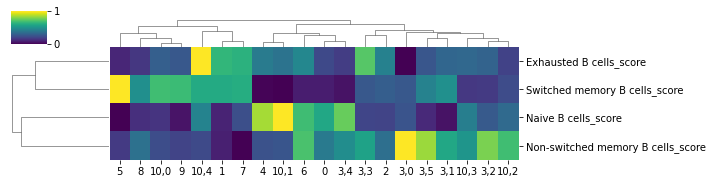

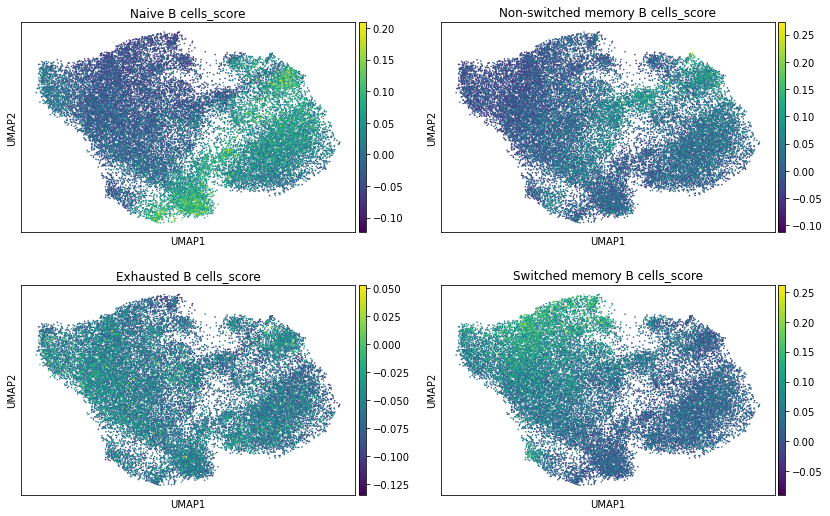

In [167]:
summarised_geneset_scores(bmem, ['Naive B cells_score', 
                                  'Non-switched memory B cells_score', 
                                  'Exhausted B cells_score', 
                                  'Switched memory B cells_score'], 
                          'leiden_B2',
                          (10,2.5))

... storing 'celltype_B' as categorical


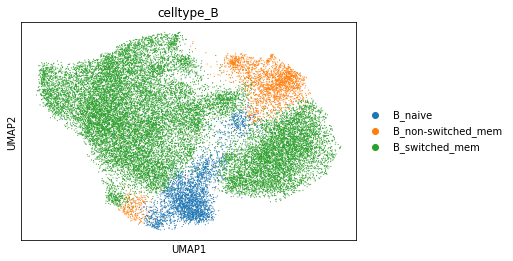

In [168]:
b_dict = {'0':'B_switched_mem',
'1':'B_switched_mem',
'2':'B_switched_mem',
'3,0':'B_switched_mem',
'3,1':'B_switched_mem',
'3,2':'B_switched_mem',
'3,3':'B_switched_mem',
'3,4':'B_naive',
'3,5':'B_switched_mem',
'4':'B_naive',
'5':'B_switched_mem',
'6':'B_non-switched_mem',
'7':'B_switched_mem',
'8':'B_switched_mem',
'9':'B_switched_mem',
'10,0':'B_switched_mem',
'10,1':'B_naive',
'10,2':'B_non-switched_mem',
'10,3':'B_non-switched_mem',
'10,4':'B_switched_mem',}
bmem.obs['celltype_B'] = [b_dict[x] for x in bmem.obs['leiden_B2']]
sc.pl.umap(bmem, color = 'celltype_B')

... storing 'celltype_B' as categorical


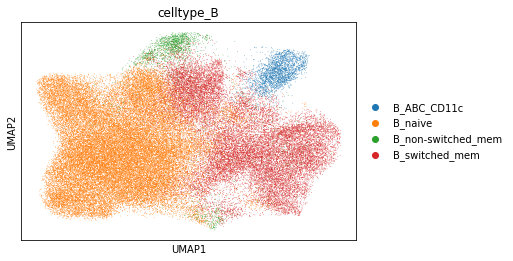

In [169]:
bcell.obs['celltype_B'] = bcell.obs['celltype_B'].astype('object')
bcell.obs['celltype_B'].update(pd.Series(bmem.obs['celltype_B']))
sc.pl.umap(bcell, color = 'celltype_B')

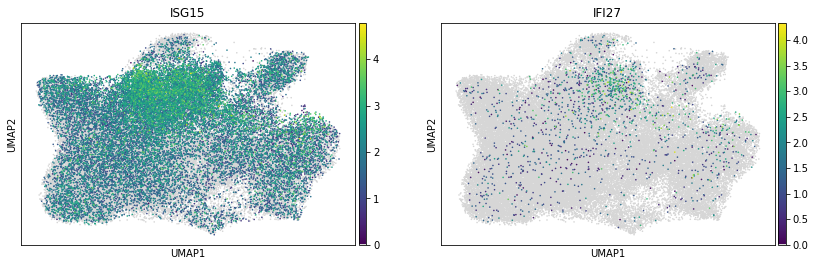

In [171]:
sc.pl.umap(bcell, color = ['ISG15', 'IFI27'], color_map = tools.cmp(), size = 10)

In [181]:
bnav = bcell[bcell.obs['celltype_B'].isin(['B_naive'])].raw.to_adata()

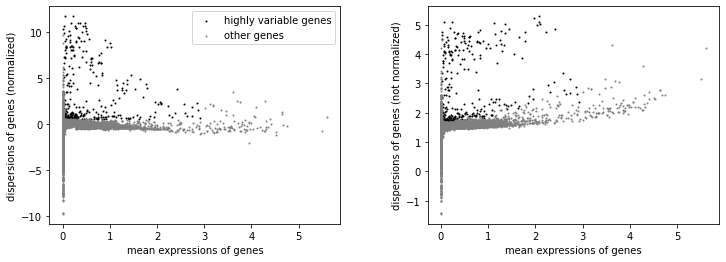

In [182]:
# find highly variable genes
sc.pp.highly_variable_genes(bnav, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(bnav)

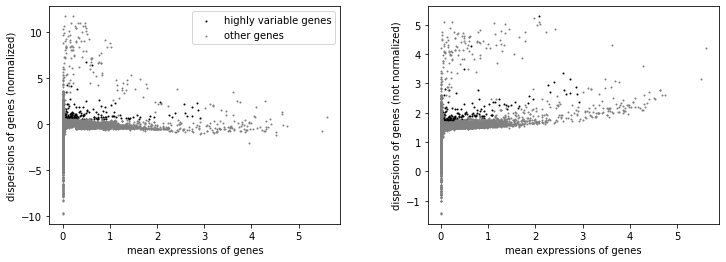

In [183]:
# remove vdj and light chain constant genes from highly variable genes, and also the viral reads
import re
for i in bnav.var.index:
    if re.search('^IG[HKL][VDJC]|VIRAL', i):
        bnav.var.at[i, 'highly_variable'] = False
sc.pl.highly_variable_genes(bnav)

In [184]:
# transfer to .raw slot
bnav.raw = bnav

In [185]:
# Filter the rna genes to only those marked as highly-variable
bnav = bnav[:, bnav.var.highly_variable].copy()
bnav

AnnData object with n_obs × n_vars = 41313 × 330
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartment

In [186]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
sc.pp.regress_out(bnav, ['nCount_RNA', 'pct_counts_mt'])
sc.pp.scale(bnav, max_value=10)

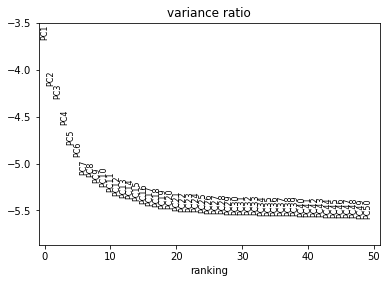

In [187]:
# Run PCA
sc.tl.pca(bnav, svd_solver='arpack')
sc.pl.pca_variance_ratio(bnav, log=True, n_pcs = 50)

In [192]:
# Correcting the PCs with harmonypy
sc.external.pp.harmony_integrate(bnav, 'sample_id', adjusted_basis = 'X_pca', max_iter_harmony =30)
# Computing the neighborhood graph
sc.pp.neighbors(bnav, n_neighbors=10, n_pcs=20)
# Embedding the neighborhood graph
sc.tl.umap(bnav, min_dist = 0.3)

2021-12-13 12:29:37,623 - harmonypy - INFO - Iteration 1 of 30
2021-12-13 12:30:18,458 - harmonypy - INFO - Iteration 2 of 30
2021-12-13 12:30:58,364 - harmonypy - INFO - Iteration 3 of 30
2021-12-13 12:31:37,347 - harmonypy - INFO - Iteration 4 of 30
2021-12-13 12:32:06,783 - harmonypy - INFO - Iteration 5 of 30
2021-12-13 12:32:32,663 - harmonypy - INFO - Iteration 6 of 30
2021-12-13 12:32:59,072 - harmonypy - INFO - Iteration 7 of 30
2021-12-13 12:33:24,047 - harmonypy - INFO - Iteration 8 of 30
2021-12-13 12:33:51,338 - harmonypy - INFO - Iteration 9 of 30
2021-12-13 12:34:24,949 - harmonypy - INFO - Iteration 10 of 30
2021-12-13 12:34:51,843 - harmonypy - INFO - Iteration 11 of 30
2021-12-13 12:35:17,792 - harmonypy - INFO - Iteration 12 of 30
2021-12-13 12:35:43,891 - harmonypy - INFO - Iteration 13 of 30
2021-12-13 12:36:10,632 - harmonypy - INFO - Iteration 14 of 30
2021-12-13 12:36:36,649 - harmonypy - INFO - Iteration 15 of 30
2021-12-13 12:37:02,715 - harmonypy - INFO - Conv

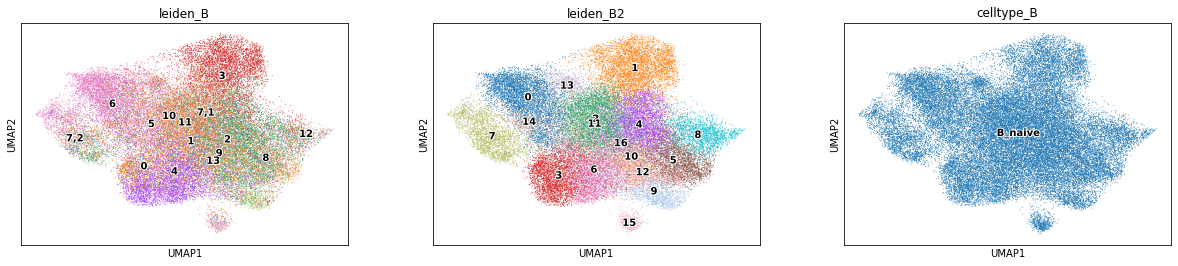

In [193]:
sc.tl.leiden(bnav, key_added = 'leiden_B2')
# sc.tl.leiden(bnav, key_added = 'leiden_B2', restrict_to = ('leiden_B2', ['3']), resolution = .5)
# sc.tl.leiden(bnav, key_added = 'leiden_B2', restrict_to = ('leiden_B2', ['10']), resolution = .5)
sc.pl.umap(bnav, color = ['leiden_B','leiden_B2', 'celltype_B'], legend_loc = 'on data', legend_fontoutline = 2)

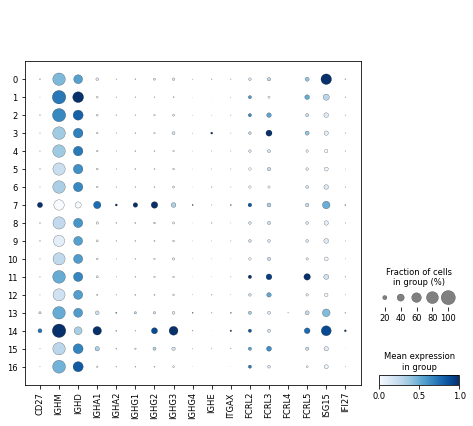

In [194]:
sc.pl.dotplot(bnav, ['CD27','IGHM','IGHD','IGHA1', 'IGHA2', 'IGHG1','IGHG2','IGHG3','IGHG4','IGHE','ITGAX', 'FCRL2','FCRL3','FCRL4','FCRL5', 'ISG15', 'IFI27'], groupby = 'leiden_B2', color_map = 'Blues', standard_scale = 'var')

In [ ]:
summarised_geneset_scores(bnav, ['Naive B cells_score', 
                                  'Non-switched memory B cells_score', 
                                  'Exhausted B cells_score', 
                                  'Switched memory B cells_score'], 
                          'leiden_B2',
                          (10,2.5))

... storing 'celltype_B' as categorical


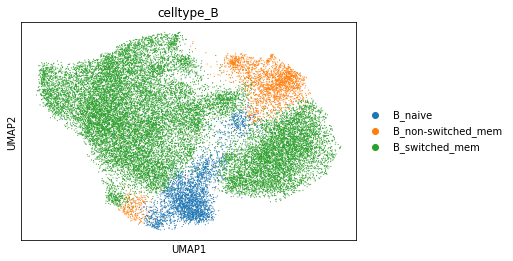

In [168]:
b_dict = {'0':'B_switched_mem',
'1':'B_switched_mem',
'2':'B_switched_mem',
'3,0':'B_switched_mem',
'3,1':'B_switched_mem',
'3,2':'B_switched_mem',
'3,3':'B_switched_mem',
'3,4':'B_naive',
'3,5':'B_switched_mem',
'4':'B_naive',
'5':'B_switched_mem',
'6':'B_non-switched_mem',
'7':'B_switched_mem',
'8':'B_switched_mem',
'9':'B_switched_mem',
'10,0':'B_switched_mem',
'10,1':'B_naive',
'10,2':'B_non-switched_mem',
'10,3':'B_non-switched_mem',
'10,4':'B_switched_mem',}
bmem.obs['celltype_B'] = [b_dict[x] for x in bmem.obs['leiden_B2']]
sc.pl.umap(bmem, color = 'celltype_B')

... storing 'celltype_B' as categorical


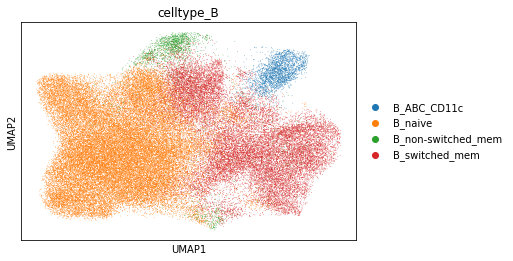

In [169]:
bcell.obs['celltype_B'] = bcell.obs['celltype_B'].astype('object')
bcell.obs['celltype_B'].update(pd.Series(bmem.obs['celltype_B']))
sc.pl.umap(bcell, color = 'celltype_B')

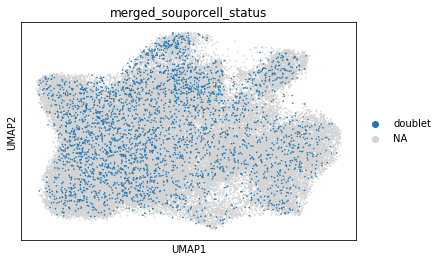

In [205]:
sc.pl.umap(bcell, color = 'merged_souporcell_status', size = 10, groups = ['doublet'])

In [197]:
bdata.obs['merged_souporcell_status'].value_counts()

singlet    71344
doublet     4339
Name: merged_souporcell_status, dtype: int64

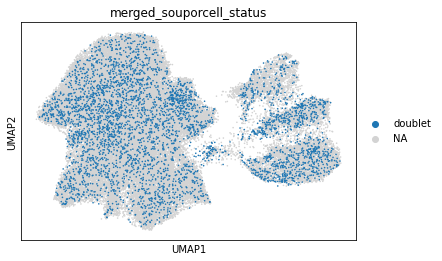

In [206]:
sc.pl.umap(bdata, color='merged_souporcell_status', size = 10, groups = ['doublet'])

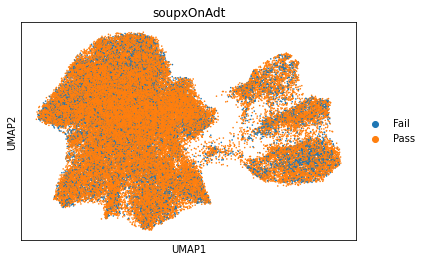

In [201]:
sc.pl.umap(bdata, color='soupxOnAdt', size = 10)

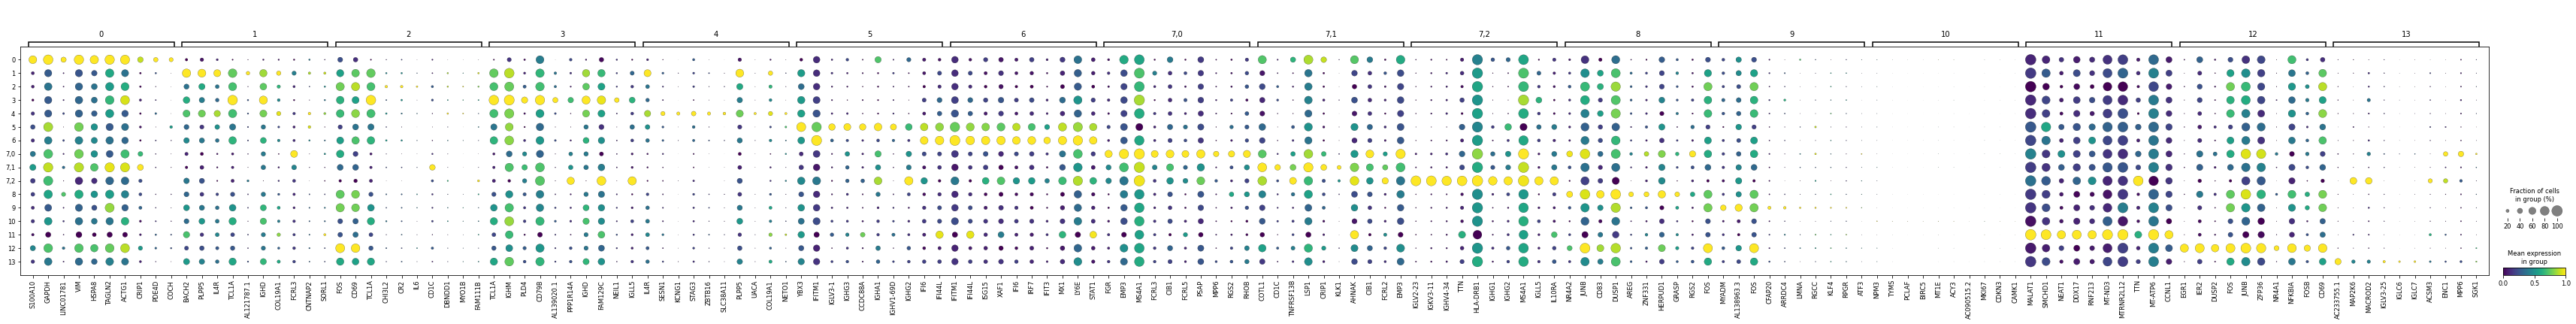

In [60]:
# sc.tl.rank_genes_groups(bcell, groupby = 'leiden_B')
sc.pl.rank_genes_groups_dotplot(bcell, min_logfoldchange =1, n_genes=10, standard_scale = 'var',  color_map = 'viridis', dendrogram = False)

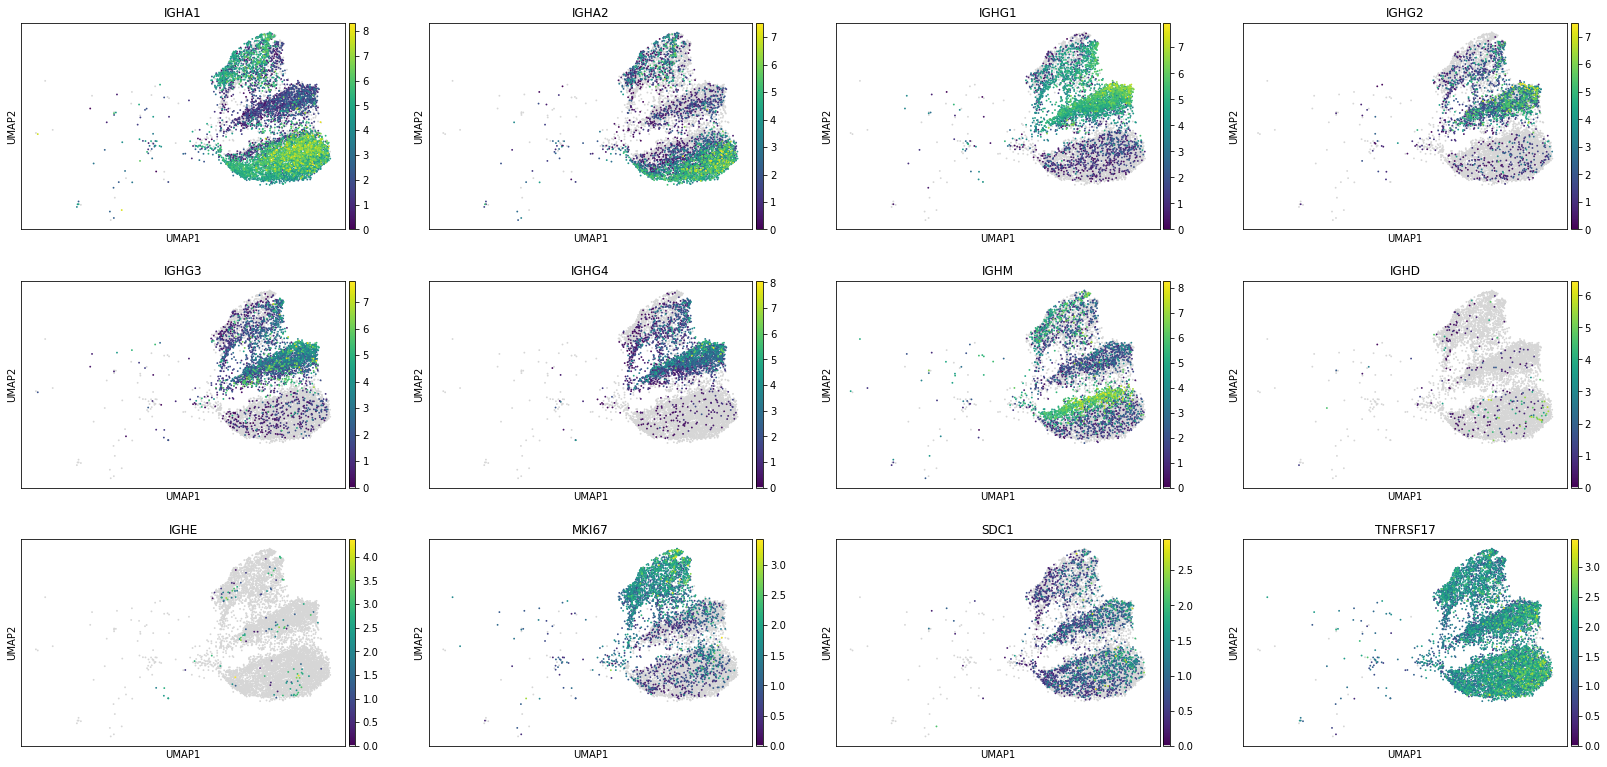

In [59]:
sc.pl.umap(ascs, color = ['IGHA1', 'IGHA2', 'IGHG1', 'IGHG2', 'IGHG3', 'IGHG4', 'IGHM', 'IGHD', 'IGHE', 'MKI67', 'SDC1', 'TNFRSF17'], color_map = tools.cmp())

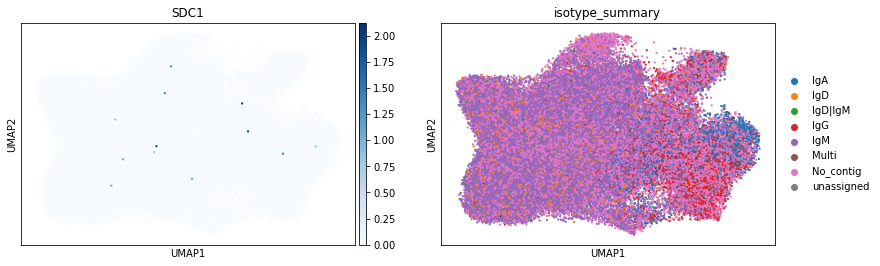

In [23]:
sc.pl.umap(bcell, color=['SDC1', 'isotype_summary'], color_map = 'Blues', size = 20, ncols = 3)

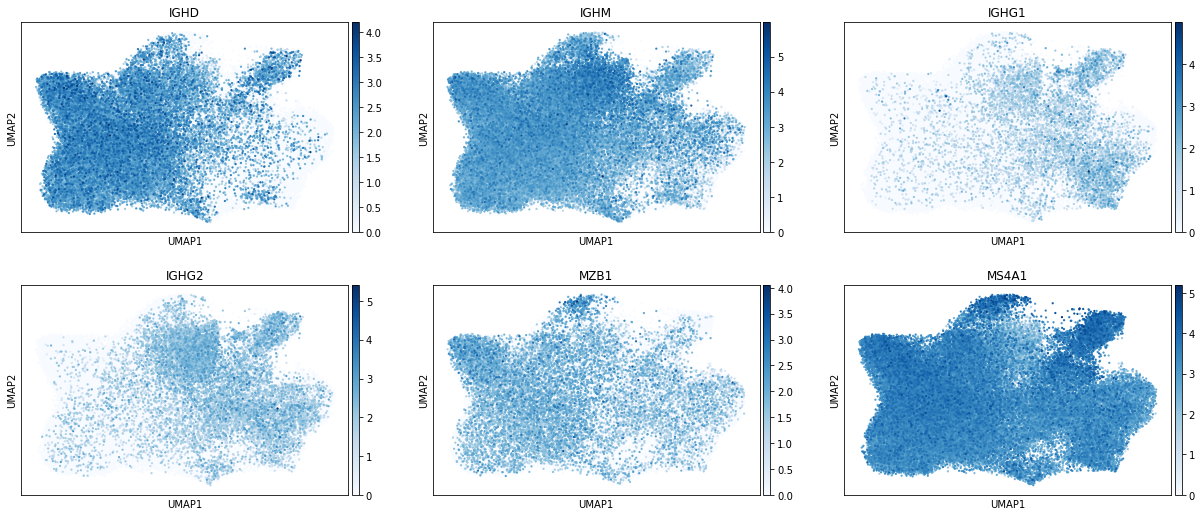

In [24]:
sc.pl.umap(bcell, color=['IGHD', 'IGHM', 'IGHG1', 'IGHG2', 'MZB1', 'MS4A1'], color_map = 'Blues', size = 20, ncols = 3)

In [ ]:
bcell.obs['']